In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

In [2]:
#读取csv中的比赛数据
dota_data = pd.read_csv("E:/learning/dota_data/dota_data.csv")
dota_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21961 entries, 0 to 21960
Data columns (total 13 columns):
Unnamed: 0     21961 non-null int64
radiant_1      21961 non-null int64
radiant_2      21961 non-null int64
radiant_3      21961 non-null int64
radiant_4      21961 non-null int64
radiant_5      21961 non-null int64
dire_1         21961 non-null int64
dire_2         21961 non-null int64
dire_3         21961 non-null int64
dire_4         21961 non-null int64
dire_5         21961 non-null int64
radiant_win    21961 non-null int64
match_id       21961 non-null int64
dtypes: int64(13)
memory usage: 2.2 MB


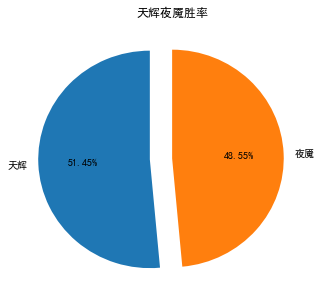

In [25]:
#先来看下天辉及夜宴方胜率
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

plt.figure(figsize=(5,5)) 
#接下来绘制饼图
plt.pie(dota_data.radiant_win.value_counts(),
        autopct = '%.2f%%',
       explode = [0.2,0],
       startangle = 90,
       labels=(u'天辉',u'夜魇'))
plt.title(u"天辉夜魇胜率")# 标题
plt.show()

In [26]:
#统计下英雄的出场率及胜率
columns=['radiant_1','radiant_2','radiant_3','radiant_4','radiant_5','dire_1','dire_2','dire_3','dire_4','dire_5']
win=np.zeros(115)
lose=np.zeros(115)
for i in range(5):
    a=dota_data.groupby([columns[i],'radiant_win'])
    s=DataFrame(a.size())
    s_sum = s.unstack()
    z=s_sum[0]
    lose+=z[0].values
    win+=z[1].values
for i in range(5,10):
    a=dota_data.groupby([columns[i],'radiant_win'])
    s=DataFrame(a.size())
    s_sum = s.unstack()
    z=s_sum[0]
    lose+=z[1].values
    win+=z[0].values
board = Series(win+lose)
win_rate =Series(win/board)
board_rate = board/21961


list = [win_rate,board_rate]
hero_rate = pd.concat(list, axis=1,)
hero_rate.to_csv('E:/learning/dota_data/hero_rate.csv')

In [5]:
def _dataset_to_features(dataset_df):
    #构造一个空的x目标矩阵，列数为英雄数量*2，行数为样本数量
    x_matrix = np.zeros((dataset_df.shape[0], 2 *120))
    
    #构造一个空的y目标矩阵，行数为样本数量
    y_matrix = np.zeros(dataset_df.shape[0])
    
    #将原样本中的数据，用pandas的values函数导出为一个numpy的矩阵类型
    dataset_np = dataset_df.values
    
    #对矩阵的每行每个英雄，分别映射到x的目标矩阵中
    for i, row in enumerate(dataset_np):
        radiant_win = row[10]        
        for j in range(5):
            x_matrix[i, row[j] - 1] = 1
            x_matrix[i, row[j+5] - 1] = 1
        #将游戏胜负映射到y的目标矩阵中
        y_matrix[i] = 1 if radiant_win else 0

    return [x_matrix, y_matrix]


In [6]:
dota_data.drop('Unnamed: 0',axis=1, inplace=True)
train_data = _dataset_to_features(dota_data)

train_data

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]), array([1., 1., 0., ..., 1., 1., 1.])]

In [7]:
train_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
train_data[0].shape

(21961, 240)

In [9]:
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold  
from sklearn.metrics import roc_curve, auc  
from scipy import interp
from sklearn.metrics import accuracy_score

G:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
x,y = train_data

In [41]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42)

In [42]:
#将数据归一化
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
cv = 10
model = LogisticRegression(C=0.005, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc',
                                           n_jobs=-1)

cv_score = np.mean(cv_scores)
cv_score

0.5036838459421645

In [44]:
model = LogisticRegression(C=0.005, random_state=42)
model.fit(x_train, y_train)
probabilities = model.predict_proba(x_test)
lr_prodict = model.predict(x_test)
lr_accuracy_score = accuracy_score(y_test, lr_prodict)
lr_accuracy_score

0.521171649719229

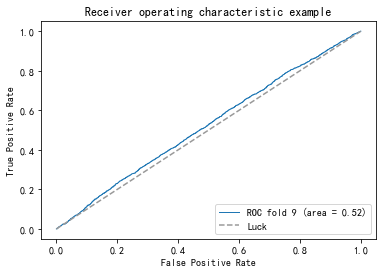

In [15]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)  
all_tpr = []  

fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0 
roc_auc = auc(fpr, tpr) 
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right") 
plt.show()

In [16]:
import xgboost as xgb

In [17]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)


G:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
gbm_accuracy_score = accuracy_score(y_test, predictions)
gbm_accuracy_score

0.5038700865078161

In [19]:
cv = 10
from sklearn import svm

model1 = svm.SVC(C=0.01,probability = True)
model1.fit(x_train, y_train) 

cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc',
                                           n_jobs=-1)

cv_score = np.mean(cv_scores)
cv_score

0.5036838459421645

In [20]:
probabilities_svm = model1.predict_proba(x_test)
svm_prodict = model.predict(x_test)
svm_accuracy_score = accuracy_score(y_test, svm_prodict)
svm_accuracy_score

0.521171649719229

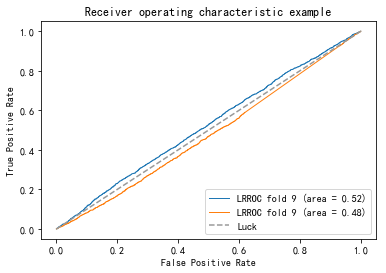

In [21]:
def roc (test,probabily):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)  
    all_tpr = []  

    fpr, tpr, thresholds = roc_curve(y_test, probabily[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, lw=1, label='LRROC fold %d (area = %0.2f)' % (i, roc_auc))

lr_roc = roc(y_test,probabilities)
roc(y_test,probabilities_svm)

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right") 
plt.show()

In [64]:
from sklearn.ensemble import AdaBoostClassifier
 
model2 = AdaBoostClassifier(n_estimators=1000, #迭代次数
                        learning_rate=0.1 #学习率
                        )
cv = 10
scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc',
                                           n_jobs=-1) #分类器的精确度  
scores.mean()  

0.5036838459421645

In [65]:
model2.fit(x_train,y_train)
adaboost_prodict = model2.predict(x_test)
ada_accuracy_score = accuracy_score(y_test, adaboost_prodict)
ada_accuracy_score

0.5205645773258462